In [52]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]

In [53]:
appliance="hvac"
cell_type = "GRU"
num_hidden = 120
num_iterations = 100
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 0.1
p = 0.5
num_folds = 5
fold_num = 0

torch.manual_seed(0)

train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, None, :, :] - train[:, 1, None, :, :]
test_aggregate = test[:, 0, None, :, :]- test[:, 1, None, :, :]

In [75]:
t = Variable(torch.Tensor(train[:, 0, None, :, :]), requires_grad=True)
t.size()

torch.Size([54, 1, 112, 24])

In [76]:
t = t.view(-1, 1, 24)
t

Variable containing:
( 0  ,.,.) = 
   1366.9166   1367.6000    899.0000  ...    5006.9668   4656.8667   1456.9333

( 1  ,.,.) = 
    946.7667    891.6500    890.1833  ...    4071.2166   3348.8833    915.8834

( 2  ,.,.) = 
   1059.1000    788.1000    610.6000  ...    2488.2334   1840.3000   1359.0167
 ... 

(6045,.,.) = 
    579.5333    661.4833    606.6166  ...     948.5667    897.8333    987.7833

(6046,.,.) = 
   1062.3667    597.3666    719.2833  ...    1208.1000   1270.4333    810.2000

(6047,.,.) = 
    511.6000    480.5333    478.1833  ...    2177.7334   1905.5834   1545.0834
[torch.FloatTensor of size 6048x1x24]

In [77]:
q1 = nn.Conv1d(1, 30, 10, 1)
q2 = nn.Conv1d(30, 30, 8, 1)
q3 = nn.Conv1d(30, 40, 6, 1)
q4 = nn.Conv1d(40, 50, 3, 1)





q4(q3(q2(q1(t)))).size()

torch.Size([6048, 50, 1])

In [78]:
train_appliance = train[:, APPLIANCE_ORDER.index(appliance),None, :, :]
test_appliance = test[:, APPLIANCE_ORDER.index(appliance),None, :, :]

In [91]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        torch.manual_seed(0)

      
        self.q1 = nn.Conv1d(1, 30, 10, 1)
        self.bn1 = nn.BatchNorm1d(30)
        self.q2 = nn.Conv1d(30, 30, 8, 1)
        self.q3 = nn.Conv1d(30, 40, 6, 1)
        self.q4 = nn.Conv1d(40, 50, 3, 1)
        self.l = nn.Linear(50, 24)
    
        
        
    def forward(self, x):
        
        pred = self.q1(x)
        pred = self.bn1(pred)
        pred = self.q2(pred)
        pred = self.q3(pred)
        pred = self.q4(pred).view(-1, 50)
        pred = self.l(pred)
        #pred = self.act2(pred)
        
        return pred

In [92]:
c = CustomCNN()
c(t)
loss_func(c(t), out)

Variable containing:
 892.5319
[torch.FloatTensor of size 1]

In [93]:
loss_func = nn.L1Loss()
c = CustomCNN()
lr = 0.001
if cuda_av:
    c = c.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(c.parameters(), lr=lr)

In [94]:
inp = t
for it in range(num_iterations):
    out = Variable(torch.Tensor(train_appliance)).view(-1, 1, 24)
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()

    
    pred = c(inp)

    optimizer.zero_grad()
    

    
    loss = loss_func(pred, out)
    if it % 1 == 0:
        print(it, loss.data[0])

    loss.backward()
    optimizer.step()

0 892.5318603515625
1 892.5123901367188
2 892.490966796875
3 892.4667358398438
4 892.4356079101562
5 892.3945922851562
6 892.3429565429688
7 892.2777709960938
8 892.1909790039062
9 892.0820922851562
10 891.9553833007812


KeyboardInterrupt: 

In [84]:
train_appliance.shape

(54, 1, 112, 24)

In [85]:
pred[0]

Variable containing:
  678.9951
  471.3506
  538.7216
  442.9084
  335.3699
   67.2930
   81.9102
  188.2203
   54.0691
   94.5408
    5.0193
   32.8533
   61.8343
   77.6725
   54.0530
  226.6035
  487.7267
 2113.0188
 1765.6757
 1428.4148
 1700.9680
 1623.1222
 1311.8258
  961.6443
[torch.FloatTensor of size 24]

In [66]:
pd.Series(pred[0].data.numpy()[0, :]).plot()
pd.Series(test_appliance[0,  :]).plot()

IndexError: too many indices for array

In [86]:
test_inp = Variable(torch.Tensor(test_aggregate).view(-1,1,24), requires_grad=False)
test_out = Variable(torch.Tensor(test_appliance).view(-1,1,24), requires_grad=False)


if cuda_av:
    test_inp = test_inp.cuda()
    
    

In [87]:
pd.Series(c(test_inp)[0].data.numpy()[0, 0, :]).plot()
pd.Series(test_out.data.numpy()[0, 0, 0, :]).plot()

IndexError: too many indices for array

In [88]:
p = c(test_inp)
p[p<0.] = 0.

In [89]:
loss_func(p, test_out)

Variable containing:
 535.2096
[torch.FloatTensor of size 1]

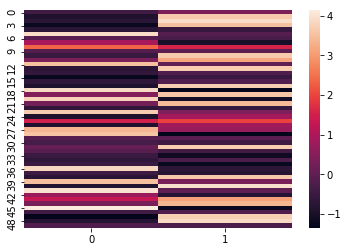

In [174]:
sns.heatmap(pd.DataFrame(list(c.parameters())[0].data.numpy().reshape(50, 2)))

In [ ]:
params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)


print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})